In [1]:

!pip install transformers

In [2]:

from transformers import TrainingArguments

In [3]:
class KnowledgeDistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):

    super().__init__(*args, **kwargs)

    self.alpha = alpha
    self.temperature = temperature


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

In [24]:
class KnowledgeDistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
    #Extract cross-entropy loss and logits from student
    outputs_student = model(**inputs)
    loss_ce = outputs_student.loss
    logits_student = outputs_student.logits

    #Extract logits from teacher
    outputs_teacher = self.teacher_model(**inputs)
    logits_teacher = outputs_teacher.logits


    #Computing distillation loss by Softening probabilities
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    #The reduction=batchmean argument in nn.KLDivLoss() specifies that we average the losses over the batch dimension.
    loss_kd = self.args.temperature ** 2 * loss_fct(
                F.log_softmax(logits_student / self.args.temperature, dim=-1),
                F.softmax(logits_teacher / self.args.temperature, dim=-1))

    # Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, outputs_student) if return_outputs else loss

In [6]:
!pip install datasets

In [7]:
from datasets import load_dataset

In [8]:
clinc = load_dataset("clinc_oos", "plus")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [9]:
sample = clinc["train"]
sample1 = clinc["train"][0]
sample2 = clinc["train"]["intent"]
print(sample)
print(sample1)
print(sample2)

Dataset({
    features: ['text', 'intent'],
    num_rows: 15250
})
{'text': 'what expression would i use to say i love you if i were an italian', 'intent': 61}
Column([61, 61, 61, 61, 61])


In [10]:
intents = clinc["train"].features["intent"]
intent = intents.int2str(sample2)
print(intent)

['translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate', 'translate'

In [11]:
from transformers import AutoTokenizer

student_checkpoint = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_checkpoint)

def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)

clinc_tokenized = clinc.map(tokenize_text, batched=True, remove_columns=["text"])

clinc_tokenized = clinc_tokenized.rename_column("intent", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [12]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00


In [13]:
import numpy as np
from evaluate import load
accuracy_score = load("accuracy")

def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [14]:
batch_size = 48
finetuned_student_ckpt = "distilbert-base-uncased-finetuned-clinc-student"

In [15]:
!pip install accelerate

In [16]:
student_training_args = KnowledgeDistillationTrainingArguments(
    output_dir=finetuned_student_ckpt, eval_strategy = "epoch",
    num_train_epochs=1, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=0.7, weight_decay=0.01)


In [17]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [18]:
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_checkpoint, num_labels=num_labels,
                                    id2label=id2label, label2id=label2id))

In [19]:
import torch
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def student_init():
  return (AutoModelForSequenceClassification.from_pretrained(student_checkpoint, config=student_config).to(device))

In [20]:
teacher_checkpoint = "transformersbook/bert-base-uncased-finetuned-clinc"

In [21]:
teacher_model = (AutoModelForSequenceClassification
                     .from_pretrained(teacher_checkpoint, num_labels=num_labels)
                     .to(device))

In [25]:
#Lets start the training
distilbert_trainer = KnowledgeDistillationTrainer(model_init=student_init,
        teacher_model=teacher_model, args=student_training_args,
        train_dataset=clinc_tokenized['train'], eval_dataset=clinc_tokenized['validation'],
        compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distilbert_trainer.train()

/tmp/ipython-input-442131491.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KnowledgeDistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.158187,0.561290


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=318, training_loss=3.4855189293435536, metrics={'train_runtime': 3533.1386, 'train_samples_per_second': 4.316, 'train_steps_per_second': 0.09, 'total_flos': 83004337293780.0, 'train_loss': 3.4855189293435536, 'epoch': 1.0})

In [26]:
def save_teacher_model():
  teacher_model.save_pretrained("teacher_model")
def save_student_model():
  distilbert_trainer.save_model('student_model')

In [27]:
save_teacher_model()
save_student_model()

In [28]:
from transformers import AutoConfig, AutoModelForSequenceClassification
import os

def compute_parameters(model_path):
  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  parameters = model.num_parameters()
  return parameters

In [29]:
teacher_model_parameters = compute_parameters(model_path="/content/teacher_model")
print("Teacher Model: ", teacher_model_parameters)

Teacher Model:  109598359


In [30]:
student_model_parameters = compute_parameters(model_path="/content/student_model")
print("Student Model: ", student_model_parameters)

Student Model:  67069591


In [31]:

decrease = (student_model_parameters-teacher_model_parameters)/teacher_model_parameters
print(decrease*100)

-38.804201438818986


In [32]:
!ls /content/student_model -al --block-size=MB

total 270MB
drwxr-xr-x 2 root root   1MB Sep 11 19:38 .
drwxr-xr-x 1 root root   1MB Sep 11 19:38 ..
-rw-r--r-- 1 root root   1MB Sep 11 19:38 config.json
-rw-r--r-- 1 root root 269MB Sep 11 19:38 model.safetensors
-rw-r--r-- 1 root root   1MB Sep 11 19:38 special_tokens_map.json
-rw-r--r-- 1 root root   1MB Sep 11 19:38 tokenizer_config.json
-rw-r--r-- 1 root root   1MB Sep 11 19:38 tokenizer.json
-rw-r--r-- 1 root root   1MB Sep 11 19:38 training_args.bin
-rw-r--r-- 1 root root   1MB Sep 11 19:38 vocab.txt


In [33]:
!ls /content/teacher_model -al --block-size=MB

total 439MB
drwxr-xr-x 2 root root   1MB Sep 11 19:37 .
drwxr-xr-x 1 root root   1MB Sep 11 19:38 ..
-rw-r--r-- 1 root root   1MB Sep 11 19:37 config.json
-rw-r--r-- 1 root root 439MB Sep 11 19:38 model.safetensors


In [34]:
from transformers import pipeline
import time

pipe = pipeline("text-classification", model="/content/teacher_model", tokenizer='bert-base-uncased')

sample_input = clinc['train']['text'][101]

#WARMUP
for _ in range(10):
  _ = pipe(sample_input)

start = time.time()
for _ in range(100):
  _ = pipe(sample_input)
total_time_teacher_model = time.time()-start
print("Total time to process 100 requests for Teacher Model: ",total_time_teacher_model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


Total time to process 100 requests for Teacher Model:  10.003488063812256


In [35]:
pipe = pipeline("text-classification", model="/content/student_model", tokenizer="distilbert-base-uncased")

sample_input = clinc['train']['text'][101]

#WARMUP
for _ in range(10):
  _ = pipe(sample_input)

start = time.time()
for _ in range(100):
  _ = pipe(sample_input)
total_time_student_model = time.time()-start

print("Total time to process 100 requests for Student Model: ",total_time_student_model)


Device set to use cpu


Total time to process 100 requests for Student Model:  8.55687689781189


In [36]:
decrease_in_time = (total_time_teacher_model-total_time_student_model)/total_time_teacher_model
print(decrease_in_time*100)

14.461067547363808


In [38]:
# Student evaluation
student_results = distilbert_trainer.evaluate()

print("Student:", student_results)

Student: {'eval_loss': 3.1581873893737793, 'eval_accuracy': 0.5612903225806452, 'eval_runtime': 212.3971, 'eval_samples_per_second': 14.595, 'eval_steps_per_second': 0.306, 'epoch': 1.0}



📊 Teacher Results:
Accuracy:  0.9429
Precision: 0.9464
Recall:    0.9429
F1 Score:  0.9418

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.75      0.86        20
           2       1.00      0.90      0.95        20
           3       0.95      1.00      0.98        20
           4       0.95      1.00      0.98        20
           5       0.95      0.95      0.95        20
           6       1.00      0.85      0.92        20
           7       0.95      1.00      0.98        20
           8       1.00      0.90      0.95        20
           9       0.94      0.80      0.86        20
          10       0.87      1.00      0.93        20
          11       1.00      1.00      1.00        20
          12       1.00      0.95      0.97        20
          13       1.00      0.90      0.95        20
          14       1.00      1.00      1.00        20
          15      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

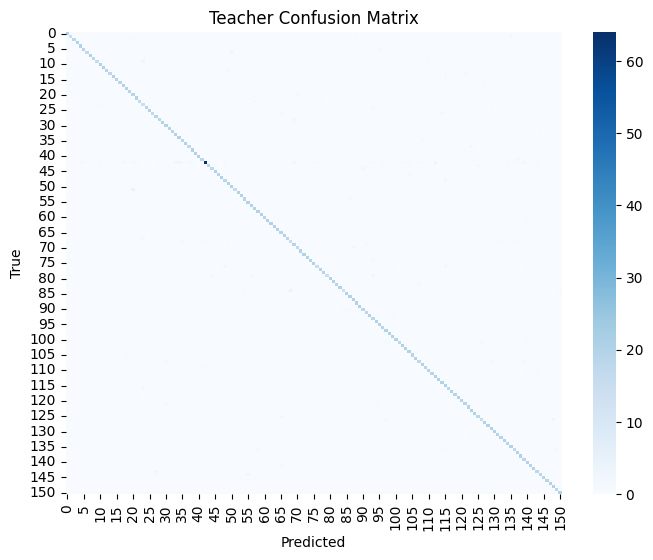

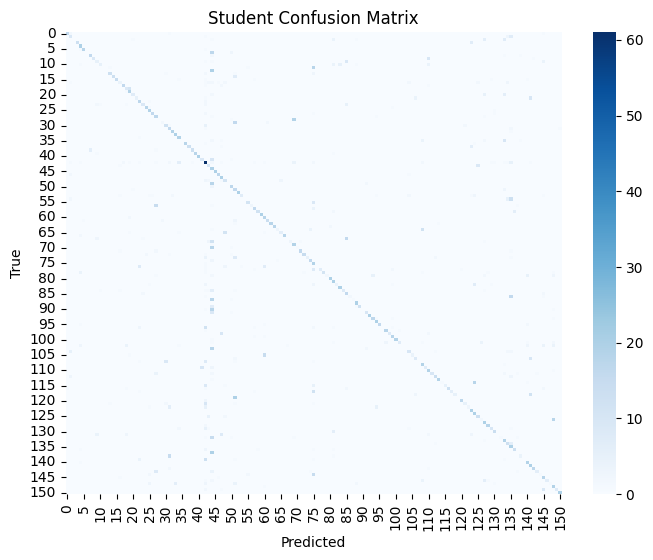

In [42]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=student_tokenizer)

def evaluate_model(model, dataloader, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
            labels.extend(batch["labels"].cpu().numpy())

    return np.array(preds), np.array(labels)

# Dataloader for validation set
val_loader = DataLoader(
    clinc_tokenized["validation"],
    batch_size=32,
    collate_fn=data_collator
)

val_loader = DataLoader(
    clinc_tokenized["validation"],
    batch_size=32,
    collate_fn=data_collator
)

# Evaluate teacher and student
teacher_preds, labels = evaluate_model(teacher_model, val_loader, device)
student_preds, _      = evaluate_model(distilbert_trainer.model, val_loader, device)

# Compute metrics
def compute_all_metrics(preds, labels, model_name):
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:\n", classification_report(labels, preds))
    return acc, precision, recall, f1, confusion_matrix(labels, preds)

# Teacher metrics
teacher_acc, teacher_prec, teacher_rec, teacher_f1, teacher_cm = compute_all_metrics(teacher_preds, labels, "Teacher")

# Student metrics
student_acc, student_prec, student_rec, student_f1, student_cm = compute_all_metrics(student_preds, labels, "Student")

# Confusion Matrix Plot
def plot_confusion(cm, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion(teacher_cm, "Teacher Confusion Matrix")
plot_confusion(student_cm, "Student Confusion Matrix")
